## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import time
import csv
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd

Using TensorFlow backend.


In [2]:
DATASET_DIR = './images/train'
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

annotations = []
classes = set([])

for xml_file in [f for f in os.listdir(DATASET_DIR) if f.endswith(".xml")]:
  tree = ET.parse(os.path.join(DATASET_DIR, xml_file))
  root = tree.getroot()

  file_name = None

  for elem in root:
    if elem.tag == 'filename':
      file_name = os.path.join(DATASET_DIR, elem.text)

    if elem.tag == 'object':
      obj_name = None
      coords = []
      for subelem in elem:
        if subelem.tag == 'name':
          obj_name = subelem.text
        if subelem.tag == 'bndbox':
          for subsubelem in subelem:
            coords.append(subsubelem.text)
      item = [file_name] + coords + [obj_name]
      annotations.append(item)
      classes.add(obj_name)

with open(ANNOTATIONS_FILE, 'w') as f:
  writer = csv.writer(f)
  writer.writerows(annotations)

print('Successfully converted xml to annotations.')

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{}, {}\n'.format(line,i))
    
print('Successfully converted xml to classes.')

Successfully converted xml to annotations.
Successfully converted xml to classes.


In [3]:
DATASET_DIR = './images/test'
ANNOTATIONS_FILE = 'val_annotations.csv'

annotations = []

for xml_file in [f for f in os.listdir(DATASET_DIR) if f.endswith(".xml")]:
  tree = ET.parse(os.path.join(DATASET_DIR, xml_file))
  root = tree.getroot()

  file_name = None

  for elem in root:
    if elem.tag == 'filename':
      file_name = os.path.join(DATASET_DIR, elem.text)

    if elem.tag == 'object':
      obj_name = None
      coords = []
      for subelem in elem:
        if subelem.tag == 'name':
          obj_name = subelem.text
        if subelem.tag == 'bndbox':
          for subsubelem in subelem:
            coords.append(subsubelem.text)
      item = [file_name] + coords + [obj_name]
      annotations.append(item)

with open(ANNOTATIONS_FILE, 'w') as f:
  writer = csv.writer(f)
  writer.writerows(annotations)

print('Successfully converted xml to annotations.')

Successfully converted xml to annotations.


In [4]:
annotations = pd.read_csv("annotations.csv")
annotations.head()

,./images/train/2020-06-22_16-06-25_CU.jpg,83,53,153,128,WBC
0,./images/train/2020-06-22_16-06-25_CU.jpg,348,94,420,155,WBC
1,./images/train/2020-06-22_16-06-25_CU.jpg,111,206,176,270,WBC
2,./images/train/2020-06-22_16-06-25_CU.jpg,218,537,289,601,WBC
3,./images/train/2020-06-22_16-06-25_CU.jpg,172,617,231,697,WBC
4,./images/train/2020-06-22_16-06-25_CU.jpg,744,634,808,718,WBC


In [5]:
annotations = pd.read_csv("val_annotations.csv")
annotations.head()

,./images/test/2020-06-22_16-29-31_CU.jpg,423,264,540,384,WBC
0,./images/test/2020-06-22_16-29-31_CU.jpg,518,342,635,458,WBC
1,./images/test/2020-06-22_16-29-31_CU.jpg,1151,283,1264,389,WBC
2,./images/test/2020-06-22_16-29-31_CU.jpg,863,616,984,736,WBC
3,./images/test/2020-06-22_16-29-31_CU.jpg,492,740,604,873,WBC
4,./images/test/2020-06-22_16-29-31_CU.jpg,731,808,854,926,WBC


In [6]:
classes = pd.read_csv("classes.csv")
classes.head()

,Platelets,0
0,RBC,1
1,WBC,2


In [5]:
model_path = os.path.join('.', 'snapshots', 'resnet50_coco_best_v2.1.0.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "retinanet-bbox"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, No

/home/microsisdcn/.virtualenvs/cv/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
#!keras_retinanet/bin/train.py --weights {model_path} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

#work #python keras_retinanet/bin/train.py --weights ./snapshots/resnet50_coco_best_v2.1.0.h5 --gpu 1 --step 500 --epochs 1 csv annotations.csv classes.csv 
#work #multi-gpu python keras_retinanet/bin/train.py --weights ./snapshots/resnet50_coco_best_v2.1.0.h5 --freeze-backbone --random-transform --multi-gpu 2 --multi-gpu-force --batch-size 32 --epochs 100 --steps 1000 --weighted-average --compute-val-loss csv annotations.csv classes.csv 

!keras_retinanet/bin/train.py --weights ./snapshots/resnet50_coco_best_v2.1.0.h5 --freeze-backbone --random-transform --multi-gpu 2 --multi-gpu-force --batch-size 8 --epochs 100 --steps 1000 --weighted-average --compute-val-loss csv annotations.csv classes.csv 


#https://github.com/fizyr/keras-retinanet/issues/575
#python ./keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_01.h5 ./snapshots/resnet50_csv_01_covert.h5 


#https://medium.com/@ringlayer/cardboard-box-detection-using-retinanet-keras-5d4f331d9d15

Using TensorFlow backend.
Creating model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

/home/microsisdcn/.virtualenvs/cv/lib/python3.6/site-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 27) vs (720, 256, 3, 3)).
  weight_values[i].shape))
/home/microsisdcn/.virtualenvs/cv/lib/python3.6/site-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((27,) vs (720,)).
  weight_values[i].shape))
2019-12-13 18:14:51.003127: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-12-13 18:14:51.007930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node 

2019-12-13 18:14:51.221094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Adding visible gpu devices: 0, 1
2019-12-13 18:14:51.221135: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2019-12-13 18:14:51.224168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-12-13 18:14:51.224204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      0 1 
2019-12-13 18:14:51.224220: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 0:   N Y 
2019-12-13 18:14:51.224234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 1:   Y N 
2019-12-13 18:14:51.224568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-12-13 18:14:51.225319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc




Epoch 1/100
2019-12-13 18:15:03.429707: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2019-12-13 18:15:04.121713: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2019-12-13 18:15:13.033707: W tensorflow/core/common_runtime/bfc_allocator.cc:419] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.0KiB (rounded to 1024).  Current allocation summary follows.
2019-12-13 18:15:13.033773: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 1.1KiB client-requested in use in bin.
2019-12-13 18:15:13.033794: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2019-12-13 18:15:13.033810: I tensorflow/core/common_runtime/b

2019-12-13 18:15:23.042154: W tensorflow/core/common_runtime/bfc_allocator.cc:419] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8B (rounded to 256).  Current allocation summary follows.
2019-12-13 18:15:23.042213: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 1.1KiB client-requested in use in bin.
2019-12-13 18:15:23.042231: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2019-12-13 18:15:23.042364: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (1024): 	Total Chunks: 25, Chunks in use: 25. 25.2KiB allocated for chunks. 25.2KiB in use in bin. 25.0KiB client-requested in use in bin.
2019-12-13 18:15:23.042379: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (2048): 	Total Chunks: 14, Chunks in use: 14. 28.0KiB all

2019-12-13 18:15:33.044520: W tensorflow/core/common_runtime/bfc_allocator.cc:419] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4B (rounded to 256).  Current allocation summary follows.
2019-12-13 18:15:33.044575: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 1.1KiB client-requested in use in bin.
2019-12-13 18:15:33.044591: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2019-12-13 18:15:33.044607: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (1024): 	Total Chunks: 25, Chunks in use: 25. 25.2KiB allocated for chunks. 25.2KiB in use in bin. 25.0KiB client-requested in use in bin.
2019-12-13 18:15:33.044624: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (2048): 	Total Chunks: 14, Chunks in use: 14. 28.0KiB all

2019-12-13 18:15:43.046601: W tensorflow/core/common_runtime/bfc_allocator.cc:419] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4B (rounded to 256).  Current allocation summary follows.
2019-12-13 18:15:43.046665: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 1.1KiB client-requested in use in bin.
2019-12-13 18:15:43.046680: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2019-12-13 18:15:43.046711: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (1024): 	Total Chunks: 25, Chunks in use: 25. 25.2KiB allocated for chunks. 25.2KiB in use in bin. 25.0KiB client-requested in use in bin.
2019-12-13 18:15:43.046725: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (2048): 	Total Chunks: 14, Chunks in use: 14. 28.0KiB all

^C


## Test RetinaNet model after trained

In [53]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path_t = os.path.join('.', 'snapshots', 'resnet50_csv_20_convert.h5')

# load retinanet model
model_t = models.load_model(model_path_t, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model_t.summary())

# load label to names mapping for visualization purposes

# load label to names mapping for visualization purposes
labels_to_names = {0: 'Platelets', 1: 'RBC', 2: 'WBC'}

tracking <tf.Variable 'Variable_40:0' shape=(12, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_41:0' shape=(12, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_42:0' shape=(12, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_43:0' shape=(12, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_44:0' shape=(12, 4) dtype=float32> anchors


## Run detection on example

processing time:  1.5620636940002441


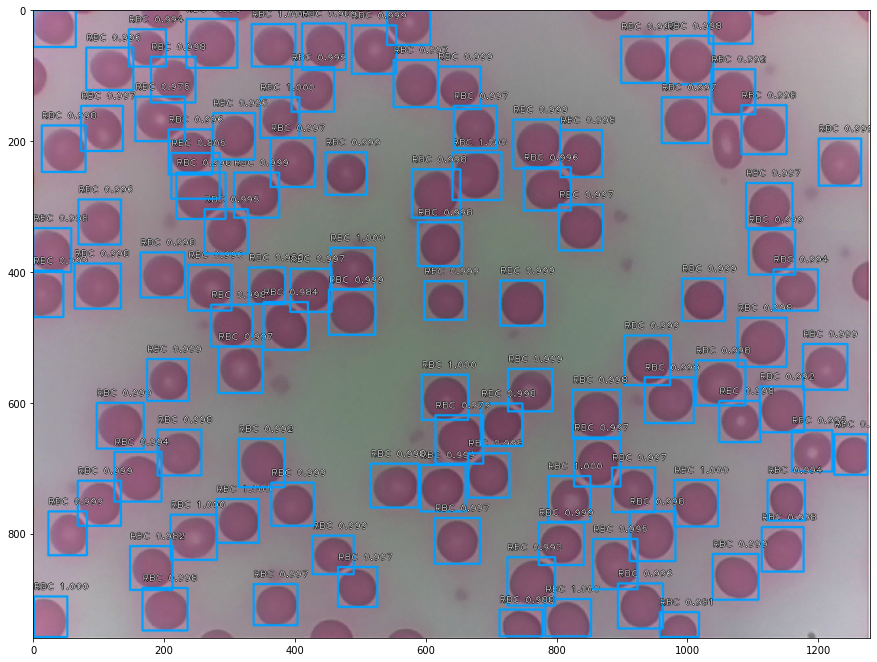

In [54]:
# load image
image = read_image_bgr('./eval_images/2020-04-16_15-58-40_CU.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model_t.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.8:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('on')
plt.imshow(draw)
plt.show()

processing time:  0.0654909610748291


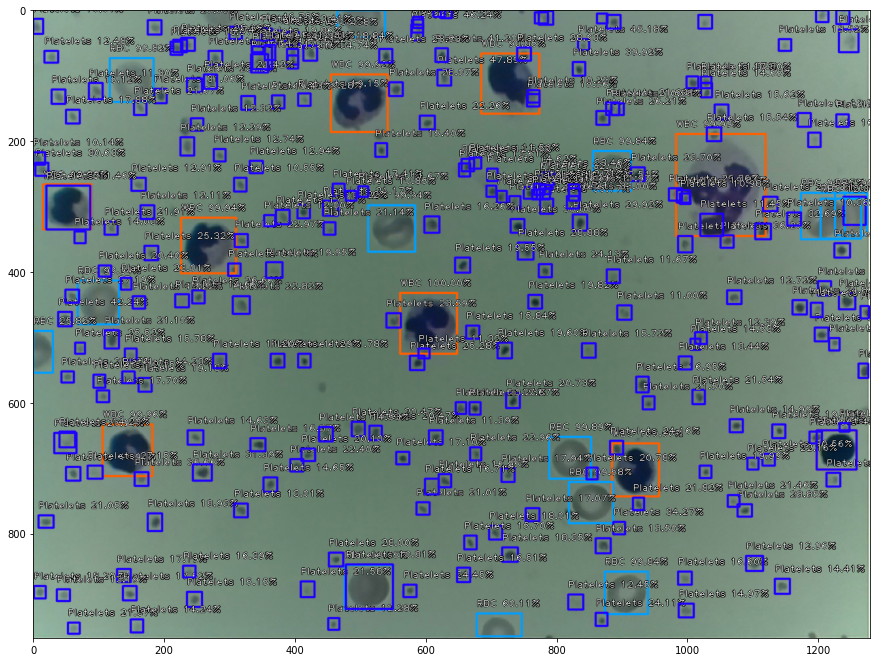

In [55]:
# load image
image = read_image_bgr('./eval_images/2020-04-18_16-06-00_CU.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model_t.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.1:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.2f}%".format(labels_to_names[label], score*100)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('on')
plt.imshow(draw)
plt.show()

processing time:  0.05754232406616211


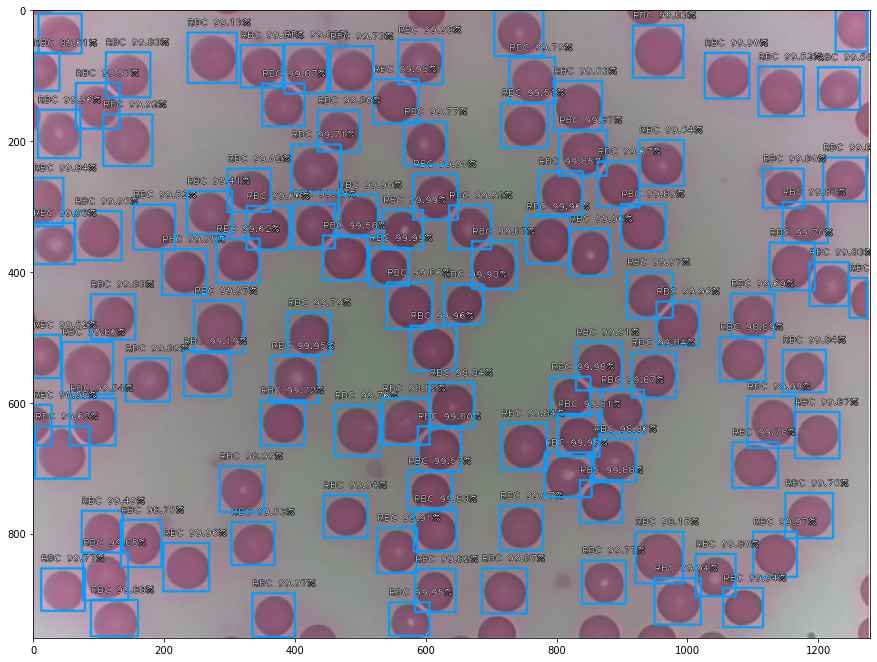

In [56]:
# load image
image = read_image_bgr('./eval_images/2020-04-16_15-58-30_CU.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model_t.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.8:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.2f}%".format(labels_to_names[label], score*100)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('on')
plt.imshow(draw)
plt.show()

processing time:  0.05553030967712402


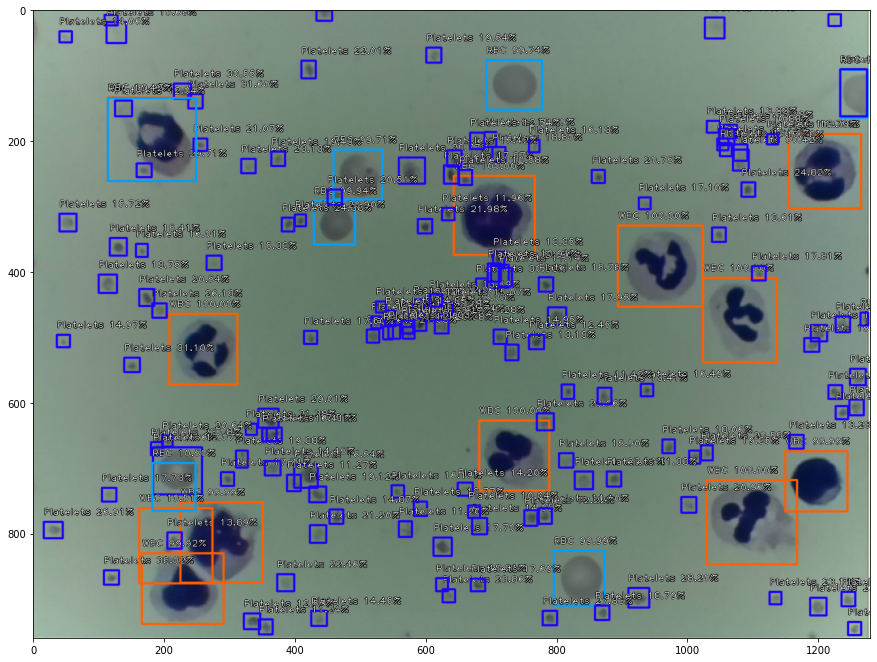

In [57]:
# load image
image = read_image_bgr('./eval_images/2020-06-22_14-10-16_CU.jpg')
#image = read_image_bgr('./images/2020-04-18_15-48-16_CU.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model_t.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.1: #default 0.5
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.2f}%".format(labels_to_names[label], score*100)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('on')
plt.imshow(draw)
plt.show()